In [291]:
from pathlib import Path 
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [247]:
dataset_path = Path().absolute()

In [248]:
def read_data(in_file: Path) -> pd.DataFrame:

    return pd.read_csv(in_file)

In [249]:
job_desc_df = read_data(dataset_path / "Train_rev1.csv")

## Exploring the Dataset

In [250]:
# Previewing the dataset

job_desc_df.head(5)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


In [251]:
num_instances: int = job_desc_df.shape[0]
num_features: int = job_desc_df.shape[1]

print(f"Number of instances available: {num_instances}")
print(f"Number of features available: {num_features}")

Number of instances available: 244768
Number of features available: 12


In [252]:
# Checking for Missing Values

job_desc_df.isna().sum()

Id                         0
Title                      1
FullDescription            0
LocationRaw                0
LocationNormalized         0
ContractType          179326
ContractTime           63905
Company                32430
Category                   0
SalaryRaw                  0
SalaryNormalized           0
SourceName                 1
dtype: int64

In [253]:
job_desc_df.describe()

,Id,SalaryNormalized
count,2.447680e+05,244768.000000
mean,6.970142e+07,34122.577576
std,3.129813e+06,17640.543124
min,1.261263e+07,5000.000000
25%,6.869550e+07,21500.000000
50%,6.993700e+07,30000.000000
75%,7.162606e+07,42500.000000
max,7.270524e+07,200000.000000


In [254]:
# convert all column names to lowercase - personal preference

job_desc_df.columns = [col.lower() for col in job_desc_df.columns]


## Subsequent Preprocessing Tasks

In [255]:
# Randomly selecting 2,500 data points from the dataframe
# adding the random_state = 42 parameter for the sake of reproducibility

job_desc_sampled = job_desc_df.sample(n = 2500, random_state = 42)

In [256]:
num_sampled_instances: int = job_desc_sampled.shape[0]
num_sampled_features: int = job_desc_sampled.shape[1]

print(f"Number of instances available post-sampling: {num_sampled_instances}")
print(f"Number of features available post-sampling: {num_sampled_features}")

Number of instances available post-sampling: 2500
Number of features available post-sampling: 12


In [257]:
# Looking for missing value counts by column in the sampled dataframe
job_desc_sampled.isna().sum()

id                       0
title                    0
fulldescription          0
locationraw              0
locationnormalized       0
contracttype          1815
contracttime           641
company                343
category                 0
salaryraw                0
salarynormalized         0
sourcename               0
dtype: int64

In [258]:
# Assigning a label based on the salarynormalized feature's value 
# since this is a supervised learning method

# assign 1 if the value is greater than or equal to the 75th percentile
# assign 0 if the value is below the 75th percentile

threshold = job_desc_sampled['salarynormalized'].quantile(0.75)

job_desc_sampled['salary_class'] = job_desc_sampled['salarynormalized'].apply(lambda row: 1 if row >= threshold else 0)

# an alternative approach could've been assigning a string "high" or "low" based on the threshold and then encoding it

In [260]:
job_desc_sampled['salary_class'].value_counts()

salary_class
0    1856
1     644
Name: count, dtype: int64

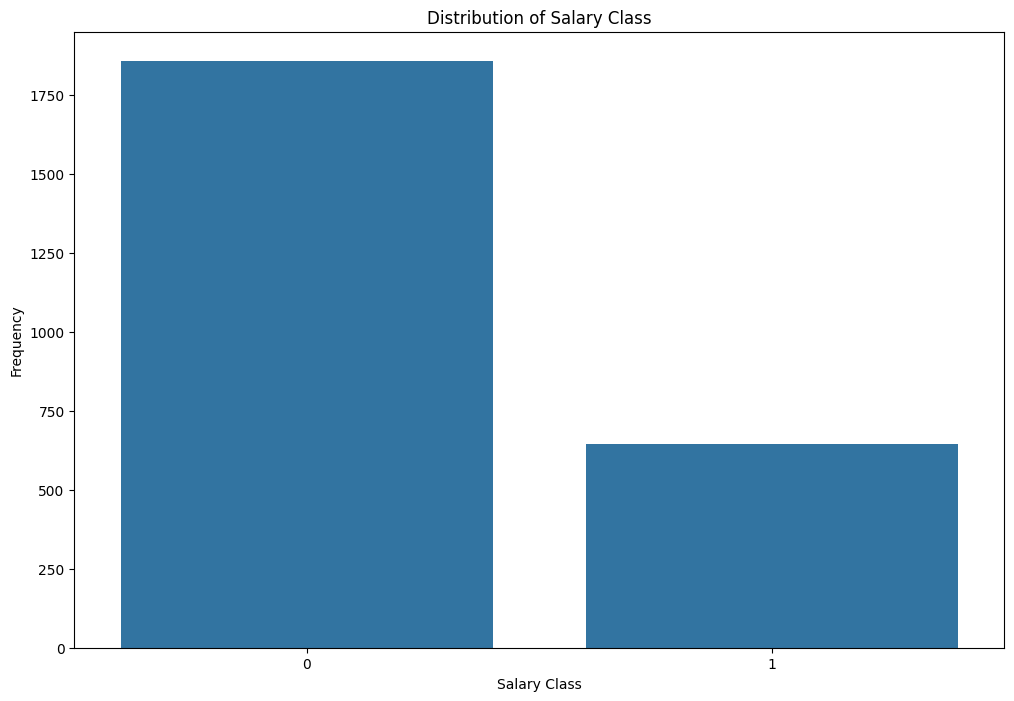

In [292]:
plt.figure(figsize=(12, 8))
sns.countplot(x='salary_class', data=job_desc_sampled)
plt.title('Distribution of Salary Class')
plt.xlabel('Salary Class')
plt.ylabel('Frequency')
plt.show()

### Train-Test Split

We're told that the classification model to predict high or low salaries comes from the text contained with the job descriptions (shortened to JD moving forward.)

Consequently, the predictor is the JD while the target is the salary class (we're trying to predict whether a given salary number will be a High (1) or Low (0) value.)

In [261]:
# Train - Test Split

job_desc_sampled['full_jd'] = job_desc_sampled['title'] + job_desc_sampled['fulldescription']

X = job_desc_sampled['full_jd']
y = job_desc_sampled['salary_class']


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

## Text Pre-Processing: Tokenization and Vectorization

 Tokenizing the entries in the JD after removing punctuations since this is a text classification task

In [269]:
def text_clean(in_text: str) -> str:

    in_text = re.sub(r"\n", "", in_text) # replacing linebreaks if any

    in_text = in_text.lower() # converting everything to lower case

    # removing digits and currency symbols if any
    in_text = re.sub(r"\d+", "", in_text)

    in_text = re.sub(r'[\$\d+\d+\$]', "", in_text)

    # remove dates
    in_text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', in_text)
    in_text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', in_text)
    in_text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', in_text)

    # remove non-ascii characters
    in_text = re.sub(r'[^\x00-\x7f]',r' ',in_text)

    # remove punctuation
    in_text = re.sub(r'[^\w\s]','',in_text)

    # remove any hyperlinks if present
    in_text = re.sub(r'https?:\/\/.*[\r\n]*', '', in_text)

    # remove stop words
    filtered_tokens = [word for word in word_tokenize(in_text) if not word in set(stopwords.words('english'))]
    in_text = " ".join(filtered_tokens)

    # lemmatization
    lemma = WordNetLemmatizer()
    lemmatized = [lemma.lemmatize(word) for word in word_tokenize(in_text)]
    lemmatized = [token for token in lemmatized if len(token) > 3]
    in_text = " ".join(lemmatized)


    return in_text

In [270]:
preprocess_text = [text_clean(text) for text in X_train]

## Setting up the CountVectorizer

In [271]:
vectorizer = CountVectorizer()

vectorized_data = vectorizer.fit_transform(preprocess_text)

## Building the Naïve-Bayes Classifier

In [272]:
# initialize the Naive-Bayes Classifier

clf = MultinomialNB()

clf.fit(vectorized_data, y_train)

MultinomialNB()

## Computing the Accuracy Score and Confusion Matrix

In [273]:
# model evaluation

y_predicted = clf.predict(vectorizer.transform(X_test))

accuracy = accuracy_score(y_test, y_predicted)

print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_predicted))

Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       368
           1       0.62      0.64      0.63       132

    accuracy                           0.80       500
   macro avg       0.74      0.75      0.75       500
weighted avg       0.80      0.80      0.80       500



CONFUSION MATRIX - MULTINOMIAL NB CLASSIFICATION


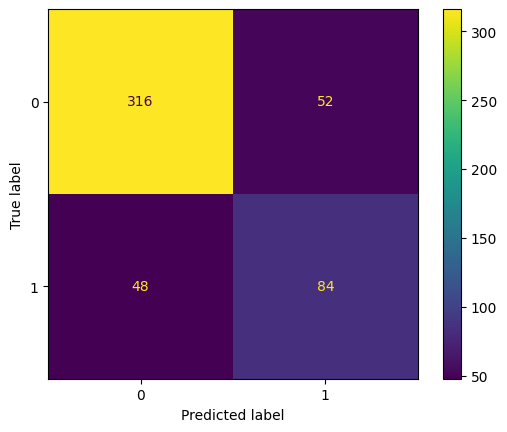

In [316]:
confuse_matrix = confusion_matrix(y_test, y_predicted)
print("CONFUSION MATRIX - MULTINOMIAL NB CLASSIFICATION")
disp = ConfusionMatrixDisplay(confusion_matrix = confuse_matrix, display_labels = clf.classes_)
disp.plot()
plt.show()

## Replicating the same using the TF-IDF Vectorizer

In [277]:
tfidf = TfidfVectorizer()

vectorized_data_tfidf = tfidf.fit_transform(preprocess_text)

clf_tfidf = MultinomialNB()
clf_tfidf.fit(vectorized_data_tfidf, y_train)

# evaluating the model

y_predicted_tfidf = clf_tfidf.predict(tfidf.transform(X_test))

accuracy_tfidf = accuracy_score(y_test, y_predicted_tfidf)

print(f"Accuracy: {accuracy_tfidf}")

print(classification_report(y_test, y_predicted_tfidf))

Accuracy: 0.736
              precision    recall  f1-score   support

           0       0.74      1.00      0.85       368
           1       0.00      0.00      0.00       132

    accuracy                           0.74       500
   macro avg       0.37      0.50      0.42       500
weighted avg       0.54      0.74      0.62       500



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


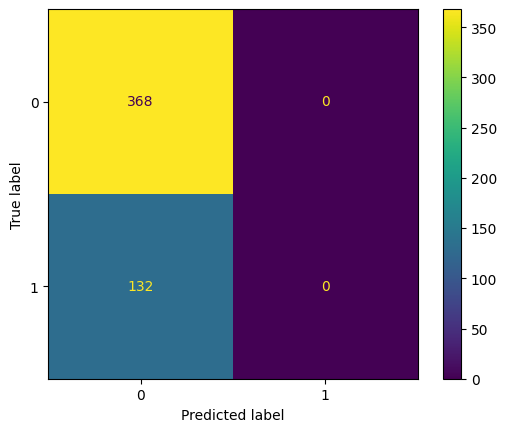

In [278]:
confuse_matrix_tf = confusion_matrix(y_test, y_predicted_tfidf)
disp_tf = ConfusionMatrixDisplay(confusion_matrix = confuse_matrix_tf, display_labels = clf_tfidf.classes_)
disp_tf.plot()
plt.show()

### Top 10 Words Indicative of High Salary

In [279]:
# spitting out the feature names from the vectorizer

feature_names = vectorizer.get_feature_names_out()

In [284]:
# calculate the log probabilities by feature by salary class

log_probabilities = clf.feature_log_prob_

In [285]:
# sorting the log probabilities and extracting those particular indices

top_10_high_indices = np.argsort(log_probabilities[1])[-10:]

top_10_high_salary_words = [feature_names[i] for i in top_10_high_indices]


In [289]:
print(f"The top 10 words indicative of high salary are: ")

for index, value in enumerate(top_10_high_salary_words):

    print(f"{index + 1} - {value}")

The top 10 words indicative of high salary are: 
1 - management
2 - development
3 - work
4 - manager
5 - role
6 - client
7 - project
8 - business
9 - team
10 - experience


### Top 10 Words Indicative of Low Salary

In [287]:
top_10_low_indices = np.argsort(log_probabilities[0])[-10:]

top_10_low_salary_words = [feature_names[i] for i in top_10_low_indices]


In [290]:
print(f"The top 10 words indicative of low salary are: ")

for index, value in enumerate(top_10_low_salary_words):

    print(f"{index + 1} - {value}")

The top 10 words indicative of low salary are: 
1 - working
2 - skill
3 - sale
4 - manager
5 - service
6 - client
7 - team
8 - work
9 - role
10 - experience


## Attempting an Improvement of the Model

### 1. Build a classification model with text (full job description) as the predictor. What is the accuracy of your model? Show the confusion matrix. Also show the top 10 words (excluding stopwords) that are most indicative of (i) high salary, and (ii) low salary.

### Interpretation of the work carried out so far:

I built two Naive-Bayes Classifiers:
- The first one uses the CountVectorizer
- The second one uses the TF-IDF Vectorizer

The CountVectorizer method gave me an accuracy of 80%. This implies that the across both low and high salary classes, the model correctly identified the salary class 80% of the time in the test dataset which was 500 instances big.

The precision associated with low salary labeling was 0.87 whereas that associated with high salary labeling was 0.62.

The TF-IDF Vectorizer method gave me an accuracy of 74% - upon a closer look, this seems to be due to the fact that no high salary labeling predictions were correct. This implies that the across both low and high salary classes, the model correctly identified the salary class 74% of the time in the test dataset which was 500 instances big.

The precision asociated with low salary labeling was 0.74 whereas that with high salary labeling was 0.00.


The lower levels of high salary labeling precision in both models can most likely be attributed to the sampling: upon taking a look at the distirbution of low vs high salary labels earlier in this notebook, we see that 1856 of 2500 labels were 0 (low) whereas only 644 of the 2500 labels were 1 (high).

The top 10 words indicating high salary include:
1. management
2. development
3. work
4. manager
5. role
6. client
7. project
8. business
9. team
10. experience

This is possibly because higher paid employees usually tend to be involved in management or even jobs such as software development etc. In addition, consulting teams or most companies work directly with clients on projects and experience is crucial here.

The top 10 words indicating low salary include:
1. working
2. skill
3. sale
4. manager
5. service
6. client
7. team
8. work
9. role
10. experience

This is possibly because lower paid employees usually tend to report to managers or even involved in service jobs. 

## 2. If you wanted to increase the accuracy of the model above, how can you accomplish this using the dataset you have?

### Possible ways to improve the model include:

- Improved Sampling: 74% of the sampled observations belonging to the low salary class definitely causes a certain degree of class imbalance. Measures that can mitigate this include:
    - Oversampling from the minority class (increasing the number of high salary observations)
    - Undersampling from the majority class (reducing the number of low salary instances)

- Hyperparameter Tuning
    - Experiment tuning the hyperparameters of the Multinomial Naive-Bayes model as well optimizing the existing vectorization process.

- Use other variations of the Naive Bayes Classifiers
    - Experimenting using Gaussian or Bernoulli Naive Bayes Classifiers could possibly show some improvement

- Feature Engineering
    - Could be addition of new, more important features or removing data from the job descriptions.

- N-Grams
    - It is possible that bi or trigrams can capture more context than singular words.

## Attempting Bernoulli Naive Bayes Classifier on the same data

## Result

The accuracy seems to have decreased across the board for the labeling of both low and high salary classes. However, the accuracy is indeed higher as compared to the TF-IDF vectorizer.

Accuracy: 0.756
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       368
           1       0.59      0.24      0.34       132

    accuracy                           0.76       500
   macro avg       0.68      0.59      0.60       500
weighted avg       0.73      0.76      0.72       500



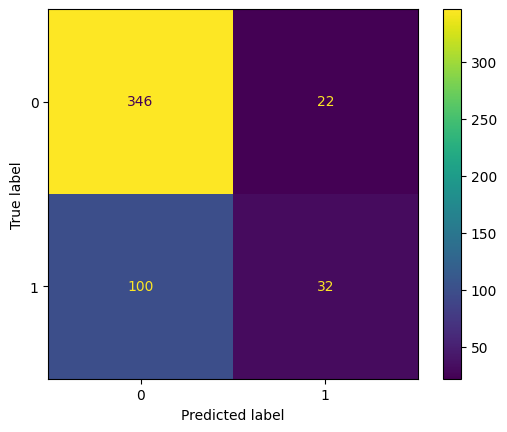

In [297]:
from sklearn.naive_bayes import BernoulliNB

# initialize the Naive-Bayes Classifier

clf_ber = BernoulliNB()

clf_ber.fit(vectorized_data, y_train)

# model evaluation

y_predicted_ber = clf_ber.predict(vectorizer.transform(X_test))

accuracy_ber = accuracy_score(y_test, y_predicted_ber)

print(f"Accuracy: {accuracy_ber}")

print(classification_report(y_test, y_predicted_ber))

confuse_matrix_b = confusion_matrix(y_test, y_predicted_ber)
disp = ConfusionMatrixDisplay(confusion_matrix = confuse_matrix_b, display_labels = clf_ber.classes_)
disp.plot()
plt.show()

### Exploring Hyper-Parameter Tuning of the Naive Bayes Model using Grid Search

In [301]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [302]:
model = Pipeline([
        ('vectorizer', TfidfVectorizer(stop_words='english')),
        ('classifier', MultinomialNB())
    ])

In [306]:
params = {
    'vectorizer': [TfidfVectorizer(stop_words= 'english'), CountVectorizer(stop_words='english')],
    'vectorizer__max_df': (0.25, 0.5, 0.75, 1),
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'classifier__alpha': (0.001, 0.01, 0.1, 1, 10, 50)
}

In [312]:
# performign grid-search

grids = GridSearchCV(model, params, cv = 5, n_jobs = -1, verbose = 1)

grids.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'classifier__alpha': (0.001, 0.01, 0.1, 1, 10, 50),
                         'vectorizer': [TfidfVectorizer(stop_words='english'),
                                        CountVectorizer(stop_words='english')],
                         'vectorizer__max_df': (0.25, 0.5, 0.75, 1),
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [313]:
model_best_one = grids.best_estimator_

In [314]:
model_best_one

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.75, stop_words='english')),
                ('classifier', MultinomialNB(alpha=0.001))])

In [310]:
# Running a new Naive Bayes Model on both using the params just obtained

tfidf_hyper = TfidfVectorizer(max_df = 0.75, stop_words = 'english')

vectorized_data_tfidf_hyper = tfidf_hyper.fit_transform(preprocess_text)

clf_tfidf_hyper = MultinomialNB()
clf_tfidf_hyper.fit(vectorized_data_tfidf_hyper, y_train)

# evaluating the model

y_predicted_tfidf_hyper = clf_tfidf_hyper.predict(tfidf_hyper.transform(X_test))

accuracy_tfidf_hyper = accuracy_score(y_test, y_predicted_tfidf_hyper)

print(f"Accuracy: {accuracy_tfidf_hyper}")

print(classification_report(y_test, y_predicted_tfidf_hyper))

Accuracy: 0.736
              precision    recall  f1-score   support

           0       0.74      1.00      0.85       368
           1       0.00      0.00      0.00       132

    accuracy                           0.74       500
   macro avg       0.37      0.50      0.42       500
weighted avg       0.54      0.74      0.62       500



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.766
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       368
           1       0.58      0.43      0.49       132

    accuracy                           0.77       500
   macro avg       0.69      0.66      0.67       500
weighted avg       0.75      0.77      0.75       500



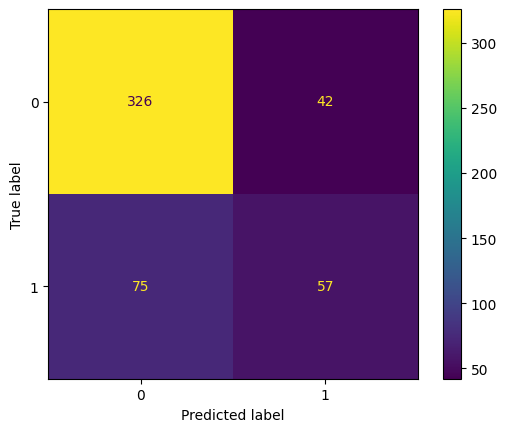

In [315]:
# initialize the Naive-Bayes Classifier

clf_multi_hyper = MultinomialNB(alpha = 0.001)

clf_multi_hyper.fit(vectorized_data, y_train)

# model evaluation

y_predicted_hyper = clf_multi_hyper.predict(vectorizer.transform(X_test))

accuracy_hyper = accuracy_score(y_test, y_predicted_hyper)

print(f"Accuracy: {accuracy_hyper}")

print(classification_report(y_test, y_predicted_hyper))

confuse_matrix_h = confusion_matrix(y_test, y_predicted_hyper)
disp = ConfusionMatrixDisplay(confusion_matrix = confuse_matrix_h, display_labels = clf_multi_hyper.classes_)
disp.plot()
plt.show()

## Observations

Hyperparameter Tuning hasn't shown increased performance in the case of a multinomial countvectorizer based Naive Bayes Classifier - in fact, the performance has declined.

The same goes for the TFIDF vectorizer based NB Classifier as well.